In [ ]:
!pip install tensorflow==2.16.2
!pip install --upgrade boto3

**IMPORTS**

In [46]:
import tensorflow as tf
# Changes AWS to True if on SageMaker Instance and set S3 BUCKET and Key accordingly
AWS = False
REGION = 'eu-west-1'
BUCKET = 'ml-can-ids-logs'
s3 = None

# Import Functions
import setuptools.dist

from importlib import reload
import utils
import anomaly_detection_functions
import clustering
import feature_selection
import train
import id_embedding

reload(utils)
reload(train)
reload(anomaly_detection_functions)
reload(clustering)
reload(feature_selection)
reload(id_embedding)

from utils import plot_loss_curve, plot_pca, plot_tsne, get_confusion_matrix, get_latent_representations_label, analyze_latent_variance, analyze_kl_divergence, linear_annealing, save_results_to_excel, save_trained_model, get_s3_client, check_dataset
from anomaly_detection_functions import get_threshold_from_train, get_threshold_from_test, anomaly_detection, get_anomaly_detection_accuracy, get_mean_variances
from clustering import visualize_anomalies, evaluate_anomaly_detector, detect_anomalies_one_class_svm_with_threshold, train_hdbscan_detector, evaluate_hdbscan_detector, detect_anomalies_hdbscan, hdbscan_set_threshold, visualize_results
from clustering import prepare_features, train_isolation_forest, train_one_class_svm, detect_anomalies_isolation_forest, detect_anomalies_one_class_svm
from feature_selection import feature_selection_preparation, convert_to_tensorflow
from train import train_model, train_model_factor , train_model_btc, train_model_bernoulli, train_model_semi
from id_embedding import train_embedding

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers, Model
import itertools
import pandas as pd
from datetime import datetime
import warnings
import keras
from scipy.stats import entropy
import scipy.stats
from tensorflow.keras.optimizers.schedules import CosineDecay
from importlib import reload
import gc
import tensorflow.keras.backend as K

if AWS:
    import boto3
    from io import StringIO

# Adjust pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # No wrapping, long rows won't be cut off
pd.set_option('display.max_colwidth', None)  # Show full column content (especially useful for long strings)

# Remove this after testing/debugging
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'  

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("✅ Using GPU")
    device = "/GPU:0"
else:
    print("❌ Using CPU")
    device = "/CPU:0"

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth set for GPUs")
    except RuntimeError as e:
        print(e)

Num GPUs Available: 0
❌ Using CPU


------------------------------------------------------------------

**PATH FILES**

In [3]:
if AWS:
    s3 = get_s3_client(REGION, BUCKET, True)
    
    # Get S3 Object 
    channel2logs = s3.get_object(Bucket = BUCKET, Key= 'channel2Logs.csv')
    dos_attack_channel2 = s3.get_object(Bucket = BUCKET, Key= 'dos_attack_channel2.csv')
    replay_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'replay_attack_channel2.csv') 
    spoofing_attack_channel2 = s3.get_object(Bucket = BUCKET, Key = 'new_spoofing_attack_channel2.csv') 

    channel2logs = channel2logs['Body'].read().decode('utf-8')
    dos_attack_channel2 = dos_attack_channel2['Body'].read().decode('utf-8')
    replay_attack_channel2 = replay_attack_channel2['Body'].read().decode('utf-8')
    spoofing_attack_channel2 = spoofing_attack_channel2['Body'].read().decode('utf-8')

    # Get Content
    channel2logs = StringIO(channel2logs)
    dos_attack_channel2 = StringIO(dos_attack_channel2)
    replay_attack_channel2 = StringIO(replay_attack_channel2)
    spoofing_attack_channel2 = StringIO(spoofing_attack_channel2)

    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = dos_attack_channel2 # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = replay_attack_channel2 # Replay on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = spoofing_attack_channel2 # Spoofing on channel 2 (Red Channel)

    # Unprocessed Channel Data
    preprocessed_normal_channel2_csv_path = channel2logs # Red Channel
    preprocessed_normal_channel4_csv_path = "" # Yellow Channel
    preprocessed_normal_channel5_csv_path = "" # Green Channel

    # Current best model
    best_model_path = ""
else:
    # Unprocessed Normal and Attack Data
    preprocessed_normal_csv_path = './Dataset/Tw22206_L003_with_ecu_channel.csv'  # Normal Unprocessed
    preprocessed_DoS_csv_path = './Dataset/Attack_Logs/dos_attack.csv'  # Dos Unprocessed
    preprocessed_Fuzzy_csv_path = './Dataset/Attack_Logs/fuzzy_attack.csv'  # Fuzzy Unprocessed
    preprocessed_Replay_csv_path = './Dataset/Attack_Logs/replay_attack.csv'  # Replay Unprocessed - Test
    preprocessed_Spoofing_csv_path = './Dataset/Attack_Logs/spoofing_attack.csv'  # Spoofing Unprocessed
    preprocessed_Suspension_csv_path = './Dataset/Attack_Logs/suspension_attack.csv'  # Suspension Unprocessed - Hardest Attack Type


    # Attack based on Channel
    preprocessed_DoS_channel2_csv_path = './Dataset/Attack_Logs/dos_attack_channel2.csv'  # DoS on channel 2 (Red Channel)
    preprocessed_Replay_channel2_csv_path = './Dataset/Attack_Logs/replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_new_Replay_channel2_csv_path = './Dataset/Attack_Logs/new_replay_attack_channel2.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_Suspension_channel2_csv_path = './Dataset/Attack_Logs/suspension_attack_channel2.csv'  # Suspension on channel 2 (Red Channel)
    preprocessed_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_new_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/new_spoofing_attack_channel2.csv'  # Spoofing on channel 2 (Red Channel)

    preprocessed_50K_Replay_channel2_csv_path = './Dataset/Attack_Logs/Replay_Attack_Channel2_50K_33s_56s.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_200K_Replay_channel2_csv_path = './Dataset/Attack_Logs/Replay_Attack_Channel2_200K_33s_169s.csv'  # Replay on channel 2 (Red Channel)
    preprocessed_1000k_Replay_channel2_csv_path = './Dataset/Attack_Logs/Replay_Attack_Channel2_1000K_33s_776s.csv'  # Replay on channel 2 (Red Channel)

    preprocessed_50K_ParkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB_Spoofing_Attack_Channel2_50K_33s_56s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_200K_ParkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB_Spoofing_Attack_Channel2_200K_33s_169s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_1000k_ParkingBrake_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/ParkingBrakeController_EPB_Spoofing_Attack_Channel2_1000K_33s_775s.csv'  # Spoofing on channel 2 (Red Channel)

    preprocessed_50K_Coordinator_K_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/Coordinator_K__Spoofing_Attack_Channel2_50K_33s_56s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_200K_Coordinator_K_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/Coordinator_K_Spoofing_Attack_Channel2_200K_33s_169s.csv'  # Spoofing on channel 2 (Red Channel)
    preprocessed_1000K_Coordinator_K_Spoofing_channel2_csv_path = './Dataset/Attack_Logs/Coordinator_K_Spoofing_Attack_Channel2_1000K_33s_776s.csv'  # Spoofing on channel 2 (Red Channel)


    # Unprocessed Channel Data
    preprocessed_normal_channel0_csv_path = './Dataset/Channel_Logs/channel0Logs.csv'  
    preprocessed_normal_channel2_csv_path = './Dataset/Channel_Logs/channel2Logs.csv'  # Red Channel
    preprocessed_normal_channel4_csv_path = './Dataset/Channel_Logs/channel4Logs.csv'  # Yellow Channel
    preprocessed_normal_channel5_csv_path = './Dataset/Channel_Logs/channel5Logs.csv'  # Green Channel


    # Preprocessed Dataframe Data
    processeddataframe_normal_csv_path = './Dataset/Processed_Dataframes/train_dataframe.csv'  # Normal CSV Dataframe (Turns Lists into Strings)
    processeddataframe_DoS_csv_path = './Dataset/Processed_Dataframes/test_DoS_dataframe.csv'  # DoS CSV Dataframe (Turns Lists into Strings)

    # Preprocessed Pickle Data
    processeddataframe_normal_pickle_path = './Dataset/Processed_Dataframes/train_Normal_dataframePickle.pkl'  # Normal Pickle Dataframe
    processeddataframe_DoS_pickle_path = './Dataset/Processed_Dataframes/test_DoS_dataframePickle.pkl'  # DoS Pickle Dataframe

    # Current best model
    best_model_path = "./Resources/Models/SOA_VAE_E6_LD38_EP30_NT100000_B1024_I42.keras"



    # PRELOAD Dataframe for Debug
    DEBUG = False 


---------------------------------------------

In [47]:
reload(utils)
reload(feature_selection)
LOAD_DATAFRAME = False
BINARY = False
BINARY_ID = False

n_rows_train = 50000  # select how many rows to load. None if whole train datasset
n_rows_test = 50000   # select how many rows to load. None if whole test datasset
batch_size = 1024 
window_size = 50    # increase window size
stride = 25     # increase stride as a buffer
split_ratio = 0.8     # % of training data to use for training
window_anomaly = 5  # For 1 anomaly per window do: 1 / window_size

if LOAD_DATAFRAME:
    # Load training data
    processeddataframe = pd.read_pickle(processeddataframe_normal_pickle_path)
    train_dataset = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size)

    # Load test data
    processeddataframe_test = pd.read_pickle(processeddataframe_DoS_pickle_path)
    test_dataset = convert_to_tensorflow(processeddataframe_test['features'] ,processeddataframe_test['type'], batch_size= batch_size )
else:
    # Preprocess and load training data
    processeddataframe , embedding_model, id_to_embedding, scalers = feature_selection_preparation(preprocessed_normal_channel2_csv_path, phase = 'training', rows=n_rows_train, binary = BINARY, binary_id= BINARY_ID)
    train_dataset, val_dataset, val_dataset2 = convert_to_tensorflow(processeddataframe['features'], batch_size= batch_size, window_size = window_size, stride = stride, split_ratio= split_ratio)

    processeddataframe_test = feature_selection_preparation(preprocessed_50K_Replay_channel2_csv_path, phase = 'test', rows=n_rows_test, binary = BINARY, binary_id = BINARY_ID, embedding_model = embedding_model, id_to_embedding = id_to_embedding, scalers = scalers)
    test_dataset, test_threshold_dataset = convert_to_tensorflow(processeddataframe_test['features'], processeddataframe_test['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly = window_anomaly)

    #processeddataframe_dos_baseline = feature_selection_preparation(preprocessed_DoS_channel2_csv_path, 'test', rows=n_rows_test)
    #dos_test_dataset, dos_threshold_dataset = convert_to_tensorflow(processeddataframe_dos_baseline['features'], processeddataframe_dos_baseline['type'], batch_size = batch_size, window_size= window_size, stride=stride, window_anomaly_ratio = window_anomaly_ratio)

#############START#####################
Amount of unique IDS in training: 96
---Training Embedding Network for Arbitration IDs---
Epoch [0/100], Loss: 0.9623
Epoch [10/100], Loss: 0.6606
Epoch [20/100], Loss: 0.3243
Epoch [30/100], Loss: 0.1252
Epoch [40/100], Loss: 0.0441
Epoch [50/100], Loss: 0.0134
Epoch [60/100], Loss: 0.0035
Epoch [70/100], Loss: 0.0010
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0001
-- ------------------ ---
Average time for ID calculations: 0.000054 seconds
Average time for payload AVERAGE calculations: 0.000023 seconds
Average time for payload CHANGE calculations: 0.000024 seconds
Average time for Entropy per ID calculations: 0.000024 seconds
Compute Temporal Features completed 6.29 seconds
Feature Selection completed in 15.99 seconds
Sliding completed (train) in 0.0000000 seconds
-----------------------------------
Original window that works:  (1999, 50, 24)
Feature shape BEFORE sliding window: (50000, 24)
Feature shape AFTER sliding window: (1999, 5

**SAVE Dataset to npz [FIX]**

In [131]:
path=r"/Users/SCHUGD/Desktop/MasterThesis/Dataset/Processed_Dataframes/Channel2_Full_43Features_WindowFeatures_1024Batch_50Window_5Stride.npz"

# Save your datasets
save_datasets(train_dataset, val_dataset, path)

# Later, load them back
train_dataset_loaded, val_dataset_loaded = load_datasets(path)

NameError: name 'save_datasets' is not defined

In [17]:
# todo: check that all values normalized or there's nans in the sliding windows
# todo: check whole processing of df
print(processeddataframe['data'].head(1))
print(processeddataframe_test['features'].head(40))
print(np.size(processeddataframe['features'][0]))

processeddataframe['has_nan'] = processeddataframe['features'].apply(lambda x: any(pd.isna(x)) if isinstance(x, list) else np.nan)
valid_lists = [lst for lst in processeddataframe['features'] if isinstance(lst, list)]
all_values = sum(valid_lists, [])
has_nan = any(pd.isna(all_values))
has_out_of_bounds = any(x < 0 or x > 1 for x in all_values if isinstance(x, (int, float)))

print(f"Contains NaN: {has_nan}")
print(f"Contains values <0 or >1: {has_out_of_bounds}")

# Run checks for both datasets
check_dataset(train_dataset, "Train Dataset")
check_dataset(val_dataset, "Validation Dataset")

0    fc ff ff ff 03 ff ff ff
Name: data, dtype: object
0         [-0.08122295141220093, 0.7345176339149475, 1.0333632230758667, -0.22652998566627502, -0.4360668957233429, -0.9412785172462463, -0.3866313695907593, -0.1063016876578331, -0.11678656935691833, 0.9274997115135193, 1.1056145632181635, 1.3877915599023225, 1.1978505680767773, 1.0541955577946325, -1.6219363589487317, 0.9105799921645951, 0.8720520151810353, 1.0705433888591087, -1.2895347858917685, -2.635924595755717, -1.1275400980447279, -1.1039204748460194, -2.2120422206083066, -0.348645564706883]
1     [0.3585539758205414, -0.3442785143852234, -0.707741916179657, 0.13371169567108154, 0.25343528389930725, -0.16143420338630676, -0.19715851545333862, -0.48035043478012085, -0.05283256992697716, -0.6982239484786987, -1.5598046651515993, 1.2618449564047536, -1.3125546255082485, 1.0541955577946325, -1.0112602367907373, 0.9105799921645951, 0.8720520151810353, 0.6318626945072333, -1.2895347858917685, -2.6358997983050583, 0.4839037397645

-----------------------------------------------------------

**VAE SETUP**

In [48]:
@keras.saving.register_keras_serializable(package="VAE_Mean_Variance_Decoder")
class VAE_Mean_Variance_Decoder(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_Mean_Variance_Decoder, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            #layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
            #layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ])
        # Split into mean and logvar outputs
        self.decoder_mean = layers.TimeDistributed(layers.Dense(input_dim))
        self.decoder_logvar = layers.TimeDistributed(layers.Dense(input_dim))


    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        #print("Z Shape at Decode: " , z.shape)

        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("Z_FLAT Shape at Decode: " , z.shape)
        reconstructed_flat = self.decoder(z_flat)
        # Get mean and logvar
        mean_flat = self.decoder_mean(reconstructed_flat)
        logvar_flat = self.decoder_logvar(reconstructed_flat)
    
        # Reshape back to include samples dimension
        mean = tf.reshape(mean_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        logvar = tf.reshape(logvar_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        
        return mean, logvar

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed_mean, reconstructed_logvar = self.decode(z)

        #print("Reconstructed Mean: " , reconstructed_mean.shape)
        #print("Reconstructed Logvar: " , reconstructed_logvar.shape)


        return reconstructed_mean, reconstructed_logvar, mu, logvar
    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_Mean_Variance_Decoder, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [49]:
@keras.saving.register_keras_serializable(package="VAE_multiplesamples")
class VAE_multiplesamples(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_multiplesamples, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            #layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
            layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ]) 
        
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        #print("AT ENCODE x shape: " , x.shape)
        #print("AT ENCODE hidden shape: ", hidden.shape)
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        #print("AT DECODE: z shape " , z.shape )
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("AT DECODE: z flat shape " , z_flat.shape )

        reconstructed_flat = self.decoder(z_flat)
        #print("AT DECODE: reconstructed flat shape " , reconstructed_flat.shape )

        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        model_outputs = {}
        if latent_only:
            mu, logvar = self.encode(x)

            model_outputs['reconstructed'] = None
            model_outputs['mu'] = mu
            model_outputs['logvar'] = logvar
            
            return model_outputs
        mu, logvar = self.encode(x)
        #print("AT CALL: mu shape " , mu.shape )
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)
        #print("RECONSTRUCTED shape: ", reconstructed.shape)

        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar
        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        print("Z shape: ", z.shape)
        print("z_mean shape: ", z_mean.shape)
        print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_multiplesamples, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [50]:
@keras.saving.register_keras_serializable(package="VAE_weak_generator")
class VAE_weakGenerator(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_weakGenerator, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences= True),
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(50, activation='relu', return_sequences= True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)

        model_outputs = {}
        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar

        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_weakGenerator, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [51]:
@keras.saving.register_keras_serializable(package="VAE_2x")
class VAE_2x(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_2x, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(50, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(50, activation = 'relu', return_sequences = True), 
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)

        model_outputs = {}
        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar

        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_2x, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

In [52]:
@keras.saving.register_keras_serializable(package="VAE_2x_weak_generator")
class VAE_2x_weak_generator(Model):
    def __init__(self, input_dim, latent_dim, window_size ,**kwargs):
        super(VAE_2x_weak_generator, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(50, activation='relu', return_sequences=True), 
            #layers.BatchNormalization(), # Experiment: BN
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            #layers.BatchNormalization(),
            layers.LSTM(5, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
        #####################################################################################
        ## FactorVAE ##
        # Discriminator for TC estimation
        """
        self.discriminator = tf.keras.Sequential([
                layers.InputLayer(shape=(latent_dim,)),
                #layers.Dense(512),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(256),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                
                #layers.Dense(128),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dropout(0.2),
                #layers.BatchNormalization(),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                layers.Dense(1500),
                layers.LeakyReLU(0.2),
                #layers.Dense(1)
                layers.Dense(2)
                #layers.Dense(1, activation='sigmoid')
            ])
        """
        #####################################################################################

    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        #hidden = tf.reduce_mean(hidden, axis=1)  # Mean over time (batch_size, hidden_dim) REMOVE
        
        #hidden_pooled = tf.reduce_max(hidden, axis=1)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        #std = tf.exp(0.5 * logvar)
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        
        #print(std)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
        
    def decode(self, z):
        # Flatten the samples for decoding
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        reconstructed_flat = self.decoder(z_flat)
        # Reshape back to (n_samples, batch_size, window_size, input_dim)
        return tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))

    def call(self, x, n_samples=1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar, n_samples=n_samples)
        reconstructed = self.decode(z)

        model_outputs = {}
        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar

        return model_outputs
    #####################################################################################
    ## FactorVAE Functions ##
    """
    Following section implements FactorVAE based on:
    "Disentangling by Factorising"
    (https://arxiv.org/abs/1802.05983)

    """
    def permute_dims(self, z):
        """Permutes the batch dimension to estimate Total Correlation"""
        """Permutes each latent dimension independently to estimate Total Correlation"""
        B, D = tf.shape(z)[0], tf.shape(z)[1]  # Batch size, Latent dimension
        z_perm = tf.zeros_like(z)
        for j in range(D):
            perm = tf.random.shuffle(tf.range(B))
            z_perm = tf.tensor_scatter_nd_update(z_perm, tf.stack([tf.range(B), tf.tile([j], [B])], axis=1), tf.gather(z[:, j], perm))
        return z_perm
    
    def discriminator_loss(self, z, z_perm):
        """Compute discriminator loss for TC estimation using Dense(2)"""
        real_logits = self.discriminator(z)  # Shape: (batch_size, 2)
        fake_logits = self.discriminator(z_perm)  # Shape: (batch_size, 2)
        
        real_labels = tf.zeros((tf.shape(real_logits)[0],), dtype=tf.int32)  # Class 0 for real samples
        fake_labels = tf.ones((tf.shape(fake_logits)[0],), dtype=tf.int32)   # Class 1 for permuted samples
        
        real_loss = tf.keras.losses.sparse_categorical_crossentropy(real_labels, real_logits, from_logits=True)
        fake_loss = tf.keras.losses.sparse_categorical_crossentropy(fake_labels, fake_logits, from_logits=True)
        
        return 0.5 * (tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss))
    
    def tc_loss(self, z):
        """Estimate Total Correlation using the discriminator"""
        logits = self.discriminator(z)
        #logits_perm = self.discriminator(self.permute_dims(z))
        # Density ratio trick
        #tc = tf.reduce_mean(logits_real - logits_perm)
        #tc_2 = tf.reduce_mean(logits[:, :1] - logits[:,1:])
        tc = tf.reduce_mean(logits[:,0] - logits[:,1]) # correct?
        return tc
    
    def discriminator_acc(self, z):
        # Permute dimensions to create "fake" samples
        z_perm = self.permute_dims(z)

        # Get discriminator outputs (logits for two classes)
        logits_real = self.discriminator(z)       # Shape: (batch_size, 2)
        logits_perm = self.discriminator(z_perm)  # Shape: (batch_size, 2)

        # Compute predicted class (0 = real, 1 = permuted)
        preds_real = tf.argmax(logits_real, axis=1)
        preds_perm = tf.argmax(logits_perm, axis=1)

        # Compute accuracy: real samples should be classified as 0, permuted as 1
        acc_real = tf.reduce_mean(tf.cast(tf.equal(preds_real, 0), tf.float32))
        acc_perm = tf.reduce_mean(tf.cast(tf.equal(preds_perm, 1), tf.float32))

        # Average accuracy
        discriminator_accuracy = 0.5 * (acc_real + acc_perm)

        return discriminator_accuracy
    #####################################################################################
    ## β-TCVAE ##
    """
    Following section implements β-TCVAE based on:

    "Isolating Sources of Disentanglement in Variational Autoencoders"
    (https://arxiv.org/pdf/1802.04942).

    if gamma = alpha = 1 , the original function can be rewritten to only
    calculate the Total Correlation similar to FactorVAE
    """

    def gaussian_log_density(self,samples, mean, log_squared_scale):
        pi = tf.constant(np.pi)
        normalization = tf.math.log(2. * pi)
        #inv_sigma = tf.math.exp(-log_squared_scale)
            # Use the same transformation as in reparameterize
        var = tf.nn.softplus(log_squared_scale)  # Match the softplus used in reparameterize
        inv_sigma = 1.0 / var
        tmp = (samples - mean)
        return -0.5 * (tmp * tmp * inv_sigma + log_squared_scale + normalization)

    def b_tcvae_total_correlation_loss(self,z, z_mean, z_log_squared_scale):
        """Estimate of total correlation on a batch.
        We need to compute the expectation over a batch of: E_j [log(q(z(x_j))) -
        log(prod_l q(z(x_j)_l))]. We ignore the constants as they do not matter
        for the minimization. The constant should be equal to (num_latents - 1) *
        log(batch_size * dataset_size)
        Args:
        z: [batch_size, num_latents]-tensor with sampled representation.
        z_mean: [batch_size, num_latents]-tensor with mean of the encoder.
        z_log_squared_scale: [batch_size, num_latents]-tensor with log variance of the encoder.
        Returns:
        Total correlation estimated on a batch.

        from: ..
        """
        #print("Z shape: ", z.shape)
        #print("z_mean shape: ", z_mean.shape)
        #print("z_logvar shape: ", z_log_squared_scale.shape)
        # Compute log(q(z(x_j)|x_i)) for every sample in the batch, which is a
        # tensor of size [batch_size, batch_size, num_latents]. In the following
        log_qz_prob = self.gaussian_log_density(
            tf.expand_dims(z, 1), tf.expand_dims(z_mean, 0),
            tf.expand_dims(z_log_squared_scale, 0))
        #print("[batch_size, batch_size, num_latents]",log_qz_prob.shape)

        # Compute log prod_l p(z(x_j)_l) = sum_l(log(sum_i(q(z(z_j)_l|x_i)))
        # + constant) for each sample in the batch, which is a vector of size
        # [batch_size,].
        log_qz_product = tf.math.reduce_sum(
            tf.math.reduce_logsumexp(log_qz_prob, axis=1, keepdims=False),
            axis=1,
            keepdims=False)
        #print("[batch_size,]",log_qz_product.shape)

        # Compute log(q(z(x_j))) as log(sum_i(q(z(x_j)|x_i))) + constant =
        # log(sum_i(prod_l q(z(x_j)_l|x_i))) + constant.
        log_qz = tf.math.reduce_logsumexp(
            tf.math.reduce_sum(log_qz_prob, axis=2, keepdims=False),
            axis=1,
            keepdims=False)
        return tf.math.reduce_mean(log_qz - log_qz_product)

    #####################################################################################

    
    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(VAE_2x_weak_generator, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size  # Window size
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'])

**Bernoulli VAE**

In [53]:
@keras.saving.register_keras_serializable(package="Bernoulli_VAE")
class Bernoulli_VAE(Model):
    def __init__(self, input_dim, latent_dim, window_size,  bernoulli_prior_p=0.5 ,**kwargs):
        super(Bernoulli_VAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  
        self.bernoulli_prior_p = bernoulli_prior_p

        ## Standard VAE ##
        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            #layers.Flatten()#layers.flatten 32* 50 , if this is removed u need to uncomment pooling in encode()
            layers.GlobalAveragePooling1D()
        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean  make input smaller than latent dim?
        self.fc_logvar = tf.keras.Sequential([
            layers.Dense(latent_dim),
            layers.Activation('softplus')
        ])

        # Decoder with LSTM layers                   # Weaker Generator --> Better Encoder --> Better Latent Space?
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim,)),
            layers.RepeatVector(window_size), 
            layers.LSTM(128, activation = 'relu', return_sequences = True), 
            layers.TimeDistributed(layers.Dense(input_dim, activation='sigmoid'))  # Output must match (window_size, input_dim)
        ])
       
    ## Standard VAE Functions ##
    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        #print(logvar)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = tf.random.normal(shape=(tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(logvar)  # More stable alternative to exp UNSTABLE FIX
        #print(std)
        #print("mu shape at reparm: ", mu.shape)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)

    def decode(self, z):
        #print("z shape at deocde ", z.shape)
        reconstructed = self.decoder(z)
        #print("Reconstructed X at deocde ", reconstructed.shape)
        return reconstructed

    def call(self, x, n_samples = 1, latent_only = False):
        if latent_only:
            mu, logvar = self.encode(x)
            return _ , mu, logvar
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        reconstructed = self.decode(z)
        #print("Reconstructed X after decode and reshape ", reconstructed.shape)

        return reconstructed, mu, logvar, z
    
    def bernoulli_prior_logpdf(self, z):
        """Calculate log probability of z under a Bernoulli prior
        
        For continuous latent variables, we use a "relaxed" Bernoulli prior:
        p(z) ~ Bernoulli(p) where z is "pushed" toward 0 or 1
        """
        # Compute the log probability of z under a Bernoulli-like prior
        # p(z) ~ Bernoulli(p) where p is self.bernoulli_prior_p
        # For each dimension, we compute the probability based on how close z is to 0 or 1
        
        # Component that favors values close to 0
        log_prob_0 = tf.math.log(1 - self.bernoulli_prior_p + 1e-10) - tf.square(z) / 0.1
        
        # Component that favors values close to 1
        log_prob_1 = tf.math.log(self.bernoulli_prior_p + 1e-10) - tf.square(z - 1) / 0.1
        
        # Combine (use log-sum-exp trick for numerical stability)
        max_val = tf.maximum(log_prob_0, log_prob_1)
        log_prob = max_val + tf.math.log(
            tf.exp(log_prob_0 - max_val) + tf.exp(log_prob_1 - max_val)
        )
        
        return log_prob
    #####################################################################################

    def get_config(self):
        # Return the config of the model including custom parameters
        config = super(Bernoulli_VAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,  # Input dimension
            'latent_dim': self.fc_mu.units,  # Latent dimension
            'window_size': self.window_size,  # Window size
            "bernoulli_prior_p" : self.bernoulli_prior_p
        })
        return config

    @classmethod
    def from_config(cls, config):
        # Create the instance from config
        return cls(input_dim=config['input_dim'], latent_dim=config['latent_dim'], window_size=config['window_size'], bernoulli_prior_p = config['bernoulli_prior_p'])

**VQ-VAE**

**SEMI SUPERVISED: LR-SEMI**

In [60]:
import tensorflow_probability as tfp

tfd = tfp.distributions
"""
LR-SEMI is based on the paper:

"Semisupervised anomaly detection of multivariate time series based on a variational autoencoder"
(https://doi.org/10.1007/s10489-022-03829-1)

"""
@keras.saving.register_keras_serializable(package="LR_SEMIVAE")
class LR_SEMIVAE(Model):
    def __init__(self, input_dim, latent_dim, window_size,num_classes, lambda_cls, **kwargs):
        super(LR_SEMIVAE, self).__init__(**kwargs)
        self.input_dim = input_dim
        self.latent_dim = latent_dim
        self.window_size = window_size  
        self.num_classes = num_classes
        self.lambda_cls = lambda_cls 

        # Encoder
        self.encoder = tf.keras.Sequential([
            layers.InputLayer(shape=(window_size, input_dim)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.LSTM(128, activation='relu', return_sequences=True), 
            layers.GlobalAveragePooling1D()

        ])
        self.fc_mu = layers.Dense(latent_dim)  # Latent mean
        self.fc_logvar = layers.Dense(latent_dim)  # Latent log variance

        # Decoder with LSTM layers
        self.decoder = tf.keras.Sequential([
            layers.InputLayer(shape=(latent_dim + 1,)), # + 1 for the z + label concat
            layers.RepeatVector(window_size),  
            layers.LSTM(128, activation='relu', return_sequences=True),
            layers.TimeDistributed(layers.Dense(input_dim))  # Output must match (window_size, input_dim)
        ])

        self.LR_classifier = tf.keras.Sequential([
            layers.InputLayer(shape=(128,)),  # Sequence input shape (window_size, input_dim) Experiment: HE Init
            layers.Dense(128, activation='tanh'),  # Linear → Tanh
            layers.Dense(128, activation='tanh'),  # Final softmax layer? wrong
            layers.Dense(128),  
            layers.Dense(1, activation = 'sigmoid'),  # Final softmax layer
        ])

    def encode(self, x):
        hidden = self.encoder(x)
        mu = self.fc_mu(hidden)
        logvar = self.fc_logvar(hidden)
        logvar = tf.clip_by_value(logvar, -10, 5)  # Prevents extreme values UNSTABLE FIX
        return mu, logvar, hidden

    def reparameterize(self, mu, logvar, n_samples=1):
        eps = tf.random.normal(shape=(n_samples, tf.shape(mu)[0], tf.shape(mu)[1]))
        std = tf.sqrt(tf.nn.softplus(logvar))  # More stable alternative to exp UNSTABLE FIX
        mu = tf.expand_dims(mu, axis=0)  # Expand for n_samples
        std = tf.expand_dims(std, axis=0)
        return mu + eps * std  # Shape: (n_samples, batch_size, latent_dim)
    

    def decode(self, z, y = None, hidden = None):
        #print("AT DECODE: z shape " , z.shape )
        num_samples = tf.shape(z)[0]
        z_flat = tf.reshape(z, (-1, tf.shape(z)[-1]))  # (n_samples * batch_size, latent_dim)
        #print("AT DECODE: z flat shape " , z_flat.shape )

        y_pred = None

        if y == None:
            #print("y is none")
            #print("AT DECODE: hidden shape " , hidden.shape)
            y_pred = self.LR_classifier(hidden) 
            #print("AT DECODE: y_pred shape: ", y_pred.shape)
            y_pred = tf.cast(y_pred, tf.float32)          # ensure dtype is compatible
            #y_pred = tf.expand_dims(y_pred, axis=-1)      # shape: (batch_size, 1)
            y_repeated = tf.repeat(y_pred, repeats=num_samples, axis=0)  # shape: (n_samples * batch_size, num_classes)  
            #print("AT DECODE: y_pred_repeated shape: ", y_repeated.shape)
            ## LEFT OFF HERE: How should labels be generated if not provided, check the shapes should probably be: y_pred = [n_samples, batch_size, ] or 

        else:
            #print("AT DECODE: y shape " , y.shape )
            y = tf.cast(y, tf.float32)          # ensure dtype is compatible
            y = tf.expand_dims(y, axis=-1)      # shape: (batch_size, 1)
            y_repeated = tf.repeat(y, repeats=num_samples, axis=0)  # shape: (n_samples * batch_size, num_classes)  


     
        #print("AT DECODE: y repeated shape " , y_repeated.shape )
        z_y_flat = tf.concat([z_flat, y_repeated], axis=-1)  # shape: (n_samples * batch_size, latent_dim + num_classes)        

        #print("AT DECODE: z_y flat shape " , z_y_flat.shape )

        reconstructed_flat = self.decoder(z_y_flat)
        #print("AT DECODE: reconstructed_flat shape " , reconstructed_flat.shape )

        z_reshaped = tf.reshape(reconstructed_flat, (tf.shape(z)[0], tf.shape(z)[1], self.window_size, self.input_dim))
        return z_reshaped, y_pred

    def call(self, batch_x, batch_y = None, n_samples=1, latent_only = False):
        #print("AT CALL batch_X shape: ", batch_x.shape)
        model_outputs = {}

        if batch_y == None:
            y_hat = None
            #print("AT CALL batch_y = None")
        else:
            y_hat = batch_y
            #print("AT CALL batch_y shape: ", batch_y.shape)


        mu , logvar, hidden = self.encode(batch_x)
        #print("AT CALL: mu shape " , mu.shape )
        #print("AT CALL: logvar shape " , logvar.shape )

        z= self.reparameterize(mu, logvar, n_samples)
        #print("AT REPARAM: z shape " , z.shape )

        reconstructed, y_pred = self.decode(z, y_hat, hidden)
        #print("Reconstruction Shape : " , reconstructed.shape)

        model_outputs['reconstructed'] = reconstructed
        model_outputs['mu'] = mu
        model_outputs['logvar'] = logvar
        model_outputs['hidden'] = hidden
        model_outputs['y_pred'] = y_pred

        return model_outputs
    
    def compute_loss(self , y, reconstruction_loss, hidden = None, y_pred = None, AD = True):
        # Determine if data is labeled
        losses = {}
        is_labeled = y is not None
        #print(y_pred)
        # Mask for Normal Data
        if is_labeled:
            a_t = 1.0 - tf.cast(y, tf.float32)  # 1 for normal, 0 for abnormal [batch_size, 1]
            #print("AT COMPUTE Loss: a_t shape BEFORE squeezed " , a_t.shape )

            # Count the number of zeros and ones in y and a_t
            """
            num_zeros_y = tf.reduce_sum(tf.cast(y == 0, tf.float32))
            num_ones_y = tf.reduce_sum(tf.cast(y == 1, tf.float32))
            num_zeros_a_t = tf.reduce_sum(tf.cast(a_t == 0, tf.float32))
            num_ones_a_t = tf.reduce_sum(tf.cast(a_t == 1, tf.float32))


            print(f"Number of zeros in y: {num_zeros_y.numpy()}")
            print(f"Number of ones in y: {num_ones_y.numpy()}")
            print(f"Number of zeros in a_t: {num_zeros_a_t.numpy()}")
            print(f"Number of ones in y: {num_ones_a_t.numpy()}")"
            """
            kappa = tf.reduce_mean(a_t, axis = -1 , keepdims = True) #[batch_size , ]

        else:
            if y_pred is not None:
                y_pred = tf.cast(y_pred > 0.5, tf.float32)  # binarize probs

                a_t = 1.0 - tf.cast(y_pred, tf.float32)  # 1 for normal, 0 for abnormal [batch_size, 1]
                a_t = tf.squeeze(a_t, axis=-1)  # Now a_t shape is (1024,) [batch_size,]
                #print("AT COMPUTE Loss y_pred is not none: a_t shape " , a_t.shape )
                
                """
                num_zeros_y = tf.reduce_sum(tf.cast(y_pred == 0, tf.float32))
                num_ones_y = tf.reduce_sum(tf.cast(y_pred == 1, tf.float32))
                num_zeros_a_t = tf.reduce_sum(tf.cast(a_t == 0, tf.float32))
                num_ones_a_t = tf.reduce_sum(tf.cast(a_t == 1, tf.float32))

                
                print(f"Number of zeros in y: {num_zeros_y.numpy()}")
                print(f"Number of ones in y: {num_ones_y.numpy()}")
                print(f"Number of zeros in a_t: {num_zeros_a_t.numpy()}")
                print(f"Number of ones in y: {num_ones_a_t.numpy()}")
                """
                kappa = tf.reduce_mean(a_t, axis = -1 , keepdims = True) #[batch_size , ]
                #print(kappa)
                
        #print("AT COMPUTE loss: reconstruction loss before masking" , reconstruction_loss.shape)
        masked_recon_loss_batch = reconstruction_loss * a_t
        #print("AT COMPUTE Loss: masked_recon_loss " , masked_recon_loss.shape )

        masked_recon_loss = tf.reduce_mean(masked_recon_loss_batch)
        # 3. Classification Loss (for labeled data only)
        classification_loss = 0.0
        if is_labeled and self.lambda_cls > 0:
        # Use the latent representation to predict the label
            #z_mean = tf.reduce_mean(z, axis=0)  # Average over samples
            y_pred = self.LR_classifier(hidden) 
            y_pred = tf.cast(y_pred, tf.float32)          # ensure dtype is compatible
            y_logits = y_pred
            y_logits = tf.squeeze(y_logits, axis=-1)  # Now a_t shape is (1024,) [batch_size,]

            
            #print("AT COMPUTE Loss: y " , y.shape )
            #print("AT COMPUTE Loss: y_logits " , y_logits.shape )

            #y_logits = self.LR_classifier(z_mean)
            # Binary cross-entropy loss for classification
            classification_loss = tf.reduce_mean(
                tf.keras.losses.binary_crossentropy(
                    y, 
                    y_logits,
                    from_logits=False
                )
            )

        if AD:
            losses['classification_loss'] = classification_loss * self.lambda_cls
            losses['masked_recon_loss'] = masked_recon_loss_batch
            losses['kappa'] = kappa
        else: 
            losses['classification_loss'] = classification_loss * self.lambda_cls
            losses['masked_recon_loss'] = masked_recon_loss
            losses['kappa'] = kappa

        return losses

    def get_config(self):
        config = super(LR_SEMIVAE, self).get_config()
        config.update({
            'input_dim': self.input_dim,
            'latent_dim': self.latent_dim,
            'window_size': self.window_size,
            'num_classes': self.num_classes,
            'lambda_cls': self.lambda_cls
        })
        return config
    
    @classmethod
    def from_config(cls, config):
        return cls(**config)

--------------------------------------

**TRAINING**

steps:  200
Input Dimension = 24, Latent Dimension = 10, Beta = 3, Validation Method = B_TCVAE, Rows in Training Data = 50000, Batch Size = 1024 
Epoch 1, Train Loss: 1.458325, Val Loss: 0.792337
Epoch 2, Train Loss: 1.218361, Val Loss: 0.627746
Epoch 3, Train Loss: 1.073107, Val Loss: 0.441364
Epoch 4, Train Loss: 0.944168, Val Loss: 0.264134
Epoch 5, Train Loss: 0.821937, Val Loss: 0.123882
Epoch 6, Train Loss: 0.718034, Val Loss: 0.042690
Epoch 7, Train Loss: 0.644204, Val Loss: 0.011152
Epoch 8, Train Loss: 0.595562, Val Loss: 0.002810
Epoch 9, Train Loss: 0.555503, Val Loss: 0.000955
Epoch 10, Train Loss: 0.520500, Val Loss: 0.000427
Epoch 11, Train Loss: 0.498668, Val Loss: 0.000153
Epoch 12, Train Loss: 0.490236, Val Loss: 0.000025
Epoch 13, Train Loss: 0.483890, Val Loss: 0.000131
Epoch 14, Train Loss: 0.479395, Val Loss: 0.009059
Epoch 15, Train Loss: 0.477648, Val Loss: 0.009209
Epoch 16, Train Loss: 0.474830, Val Loss: 0.001751
Epoch 17, Train Loss: 0.472376, Val Loss: 0.000

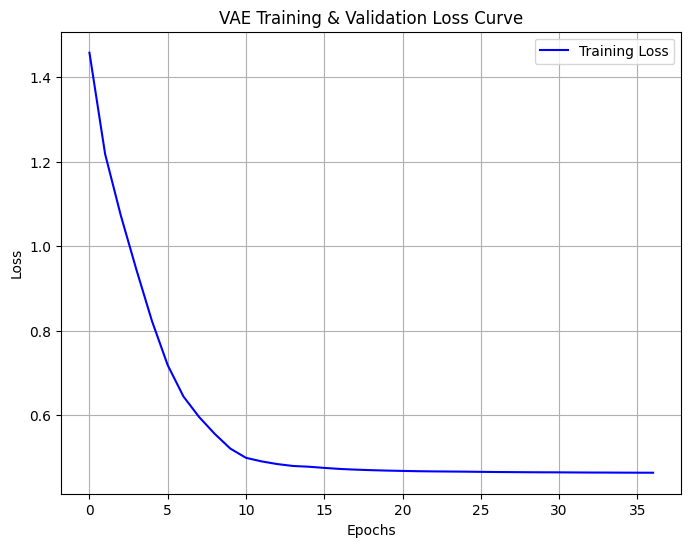

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:234: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


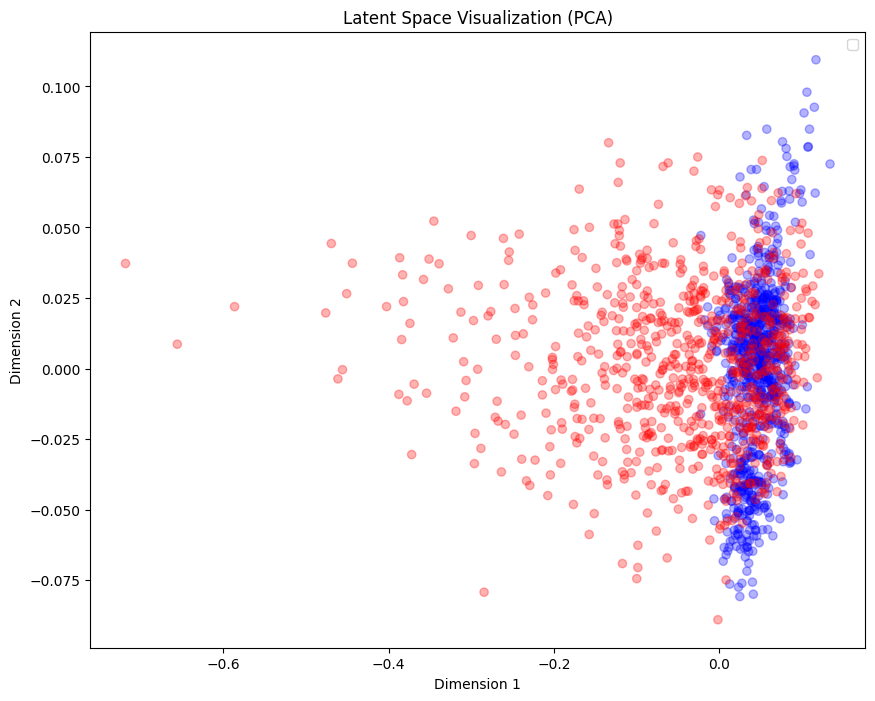

c:\Users\SCHUGD\Desktop\MasterThesis\github_USE_THIS!!\MasterThesis\utils.py:234: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


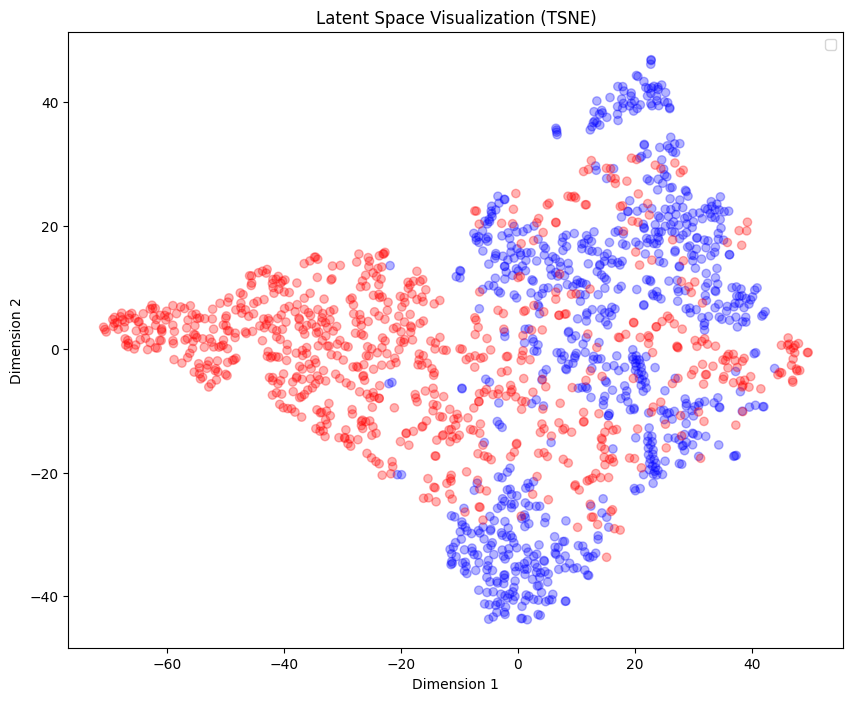

recon error from val 1.325324296951294
recon error from val 1.2959829568862915
recon error from val 1.333896279335022
recon error from val 1.3538641929626465
recon error from val 1.3369985818862915
recon error from val 1.2144509553909302
recon error from val 1.238912582397461
recon error from val 1.3084275722503662
recon error from val 1.29001784324646
recon error from val 1.3145190477371216
recon error from val 1.3177728652954102
recon error from val 1.3126832246780396
recon error from val 1.2913930416107178
recon error from val 1.2328828573226929
recon error from val 1.3195645809173584
recon error from val 1.3449246883392334
recon error from val 1.2675589323043823
recon error from val 1.339431643486023
recon error from val 1.3733335733413696
recon error from val 1.3194630146026611
recon error from val 1.3687312602996826
recon error from val 1.351752758026123
recon error from val 1.3377959728240967
recon error from val 1.33282470703125
recon error from val 1.333663821220398
recon erro

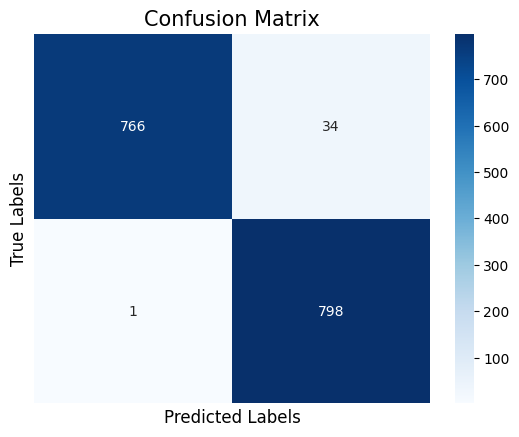

######### ############################ ############
######### Reconstruction Probability Performance ############
Confusion Matrix:
[[659 141]
 [  0 799]]

Performance Report:
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       800
           1       0.85      1.00      0.92       799

    accuracy                           0.91      1599
   macro avg       0.93      0.91      0.91      1599
weighted avg       0.93      0.91      0.91      1599



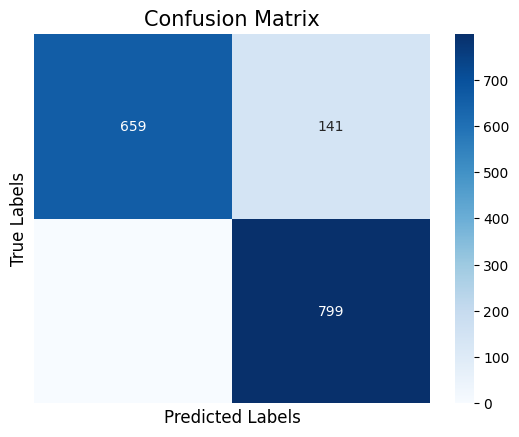

######### ############################ ############


In [63]:
reload(utils)
reload(train)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
epochs = 100
n_samples = 11
learning_rate = 1e-04
weight_decay = 1e-06
learning_rate_disc = 5e-5 # FactorVAE

steps_anneal = epochs * len(train_dataset)  
print("steps: ", steps_anneal) 
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "B_TCVAE" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 10
beta = 3 # 50
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..
gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = True

time = datetime.now().strftime("%H-%M")
model_name ="LSTM_VAE"
#model_path s= f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)


#vae = Bernoulli_VAE(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size, bernoulli_prior_p= 0.5)
#vae = VAE_Mean_Variance_Decoder(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

vae_semi = LR_SEMIVAE(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size, num_classes= 2, lambda_cls = 1)


#optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
optimizer = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model_semi(vae_semi,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= "", train_dataset = test_dataset,test_dataset = test_dataset,
                                                                      val_dataset = test_threshold_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
reducer = None
reducer = get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False, reducer = reducer)
reducer = get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs, name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)

if AD:
  reconstruction_AD = True
  latent_AD = False
  reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
  results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
  reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)

**HyperParamter Search**

In [ ]:
reload(utils)
reload(anomaly_detection_functions)
# Regular HYPERPARAMETERS 
input_dim = np.size(processeddataframe['features'][0])
#input_dim = 42
epochs = 100
n_samples = 8
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-04
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5 # increase this
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "B_VAE" # None, B_VAE, TC, B_TCVAE
patience = 5  

# IMPORTANT 
latent_dim= 2  
beta = 20 # 20
beta_tc = 0 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)

# Hyperparameter search space
latent_dims = [30, 70]  # Example values for latent dimension
beta_values = [50,100]

it = 0
reconstruction_AD = True
latent_AD = False
# Iterate over all combinations
for latent_dim, beta in itertools.product(latent_dims, beta_values):
    time = datetime.now().strftime("%H-%M")
    model_name ="BASE_LSTM_VAE"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'

    print(f"Training with: latent_dim={latent_dim}, beta={beta} validation_method={validation_method}")

    vae = VAE_multiplesamples(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_weakGen = VAE_weakGenerator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    vae_2x = VAE_2x(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)
    VAE_2x_weakGen = VAE_2x_weak_generator(input_dim=input_dim, latent_dim=latent_dim, window_size= window_size)

    #optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
    optimizer = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_weakGen = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_2x = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    optimizer_2x_weakGen = tf.keras.optimizers.AdamW(learning_rate=cosine_decay_schedule)
    discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

    print("VAE--------------")
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)


    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae, optimizer
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE WEAK GENERATOR-------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_WEAKGEN"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_weakGen = train_model(vae_weakGen,optimizer_weakGen,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae_weakGen, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")
    
    del vae_weakGen, optimizer_weakGen
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X----------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, vae_2x = train_model(vae_2x,optimizer_2x,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

    
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(vae_2x, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type = 'TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del vae_2x, optimizer_2x
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')
    
    print("VAE 2X WEAK GENERATOR------------------")
    time = datetime.now().strftime("%H-%M")
    model_name ="LSTM_VAE_2x_WEAKGEN"
    model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/BEST_{model_name}_LD{latent_dim}_Beta{beta}_NT{n_rows_train}_{time}.keras'
    train_losses, val_losses, real_epochs, time, show_val, model_path, VAE_2x_weakGen = train_model(VAE_2x_weakGen,optimizer_2x_weakGen,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path= model_path, train_dataset=train_dataset,test_dataset=test_dataset,
                                                                      val_dataset=val_dataset,n_rows_train=n_rows_train,AWS = AWS,s3 = s3, BUCKET=BUCKET)

   
    plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time,n_rows_train, show_val= show_val, AWS = AWS, s3 = s3, BUCKET = BUCKET)
    get_latent_representations_label(VAE_2x_weakGen, test_dataset, latent_dim, beta,n_critic,gamma,time,epoch = real_epochs,name = model_name,type='TSNE', save = True, AWS = AWS, s3 = s3, BUCKET = BUCKET)

    reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD, val_dataset2= val_dataset2)
    results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
    reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)
    print("-----------------------------------------------")

    del VAE_2x_weakGen, optimizer_2x_weakGen
    K.clear_session()
    gc.collect()
    #tf.config.experimental.reset_memory_stats('/GPU:0')


**Iterative Training on Saved Model**

In [ ]:
# Regular HYPERPARAMETERS 
#input_dim = np.size(processeddataframe['features'][0])
input_dim = 42
epochs = 50
n_samples = 1
# Best 512 settigns: AdamW with LR=1e-05, WD=1e-06, Beta1=0.85, Beta2=0.98  
learning_rate = 1e-04
weight_decay = 1e-06
# FactorVAE
learning_rate_disc = 5e-5
# Annealing and Early stop
steps_anneal = epochs * len(train_dataset)  
alpha = 0.0  # Minimum learning rate as a fraction of the initial learning rate
validation_method = "PLOT" # None, B_VAE, TC, B_TCVAE, PLOT
patience = 5  

# IMPORTANT 
latent_dim= 30  
beta = 0 # 20
beta_tc = 1.008 #1.008 # keep in mind this is tuned based on that we get tc loss = -244..

gamma = 0  # TC weight (typically between 1 and 10) 6
n_critic = 0
##################

AD = False

time = datetime.now().strftime("%H-%M")
model_name ="BEST_VAE"
new_model_path = f'/Users/SCHUGD/Desktop/MasterThesis/Code/Models/Iter_BEST_{model_name}_{time}.keras'

cosine_decay_schedule = CosineDecay(
    1e-03, steps_anneal, alpha=alpha
)


vae = keras.models.load_model(best_model_path)

#optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate, weight_decay=weight_decay, beta_1=beta1, beta_2=beta2)
#optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=weight_decay)
optimizer = vae.optimizer
discriminator_optimizer = tf.keras.optimizers.AdamW(learning_rate=learning_rate_disc)

train_losses, val_losses, real_epochs, time, show_val, model_path, vae = train_model(vae,optimizer,discriminator_optimizer, epochs,
                                                                    n_samples, input_dim, latent_dim, batch_size,beta,
                                                                      gamma, n_critic, steps_anneal, patience, time,beta_tc,validation_method,
                                                                      model_path = new_model_path)


plot_loss_curve(train_losses, val_losses , real_epochs, latent_dim, time, show_val= show_val)
#analyze_latent_variance(vae,train_dataset, test_dataset)
#analyze_kl_divergence(vae, train_dataset, test_dataset)
#get_latent_representations_label(vae, test_dataset,latent_dim, beta,n_critic,gamma,time, 'PCA', save = False)
get_latent_representations_label(vae, test_dataset, latent_dim, beta,n_critic,gamma,time,'TSNE', save = True)
#get_latent_representations_label(vae, train_dataset, 'TSNE')

if AD:
  reconstruction_AD = False
  latent_AD = True
  reconstruction_threshold, latent_threshold, mean_train, variance_train = get_threshold_from_train(model_path, reconstruction_AD, latent_AD)
  results, distances = anomaly_detection(vae, reconstruction_AD, latent_AD, mean_train, variance_train)
  reconstruction_accuracy , latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,reconstruction_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time)

**Test Saved Model**

Latent Dimension = 38, Beta = 30, Gamma = 0, N_critic = 0, Beta_TC = 0, Validation Method = PLOT, Rows in Training Data = 100000, Batch Size = 1024


In [ ]:
best_model_path = "./Resources/Models/BtcVAE_EPOCHS72_LD100_BETA50_NT100000_INPUT24_15-32.keras"
load_vae = keras.models.load_model(best_model_path)
load_vae.trainable = False  # Freeze model weights
reducer = None
reducer = get_latent_representations_label(load_vae, train_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='PCA', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
reducer = get_latent_representations_label(load_vae, val_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='PCA', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
reducer = get_latent_representations_label(load_vae, test_threshold_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='PCA', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)
reducer = get_latent_representations_label(load_vae, test_dataset, 0, 0 ,0,0,0,epoch = 0,name = "-",type='PCA', save = False, AWS = AWS, s3 = s3, BUCKET = BUCKET, reducer = reducer)





recon error from val 1.145017385482788
recon error from val 1.13096022605896
recon error from val 1.1521536111831665
recon error from val 1.2234054803848267
recon error from val 1.2071239948272705
recon error from val 1.0904457569122314
recon error from val 1.104862093925476
recon error from val 1.0875229835510254
recon error from val 1.0920777320861816
recon error from val 1.1765128374099731
recon error from val 1.1491072177886963
recon error from val 1.093034267425537
recon error from val 1.1070061922073364
recon error from val 1.0745738744735718
recon error from val 1.1432496309280396
recon error from val 1.1455503702163696
recon error from val 1.0517865419387817
recon error from val 1.1038137674331665
recon error from val 1.1307063102722168
recon error from val 1.1332919597625732
recon error from val 1.158952236175537
recon error from val 1.1140064001083374
recon error from val 1.0948821306228638
recon error from val 1.1031625270843506
recon error from val 1.144286036491394
recon e

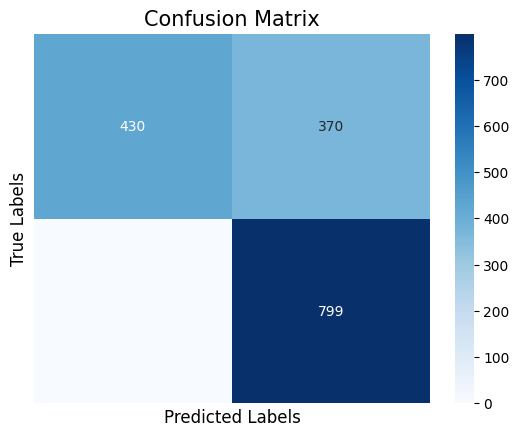

######### ############################ ############
######### Reconstruction Probability Performance ############
Confusion Matrix:
[[682 118]
 [  0 799]]

Performance Report:
              precision    recall  f1-score   support

           0       1.00      0.85      0.92       800
           1       0.87      1.00      0.93       799

    accuracy                           0.93      1599
   macro avg       0.94      0.93      0.93      1599
weighted avg       0.94      0.93      0.93      1599



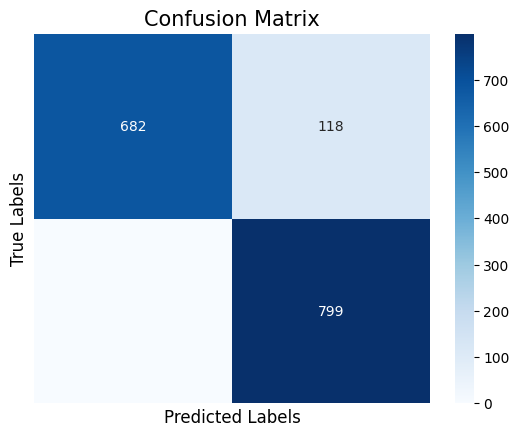

######### ############################ ############


In [ ]:
model_path = "./Resources/Models/SEMI-Supervised-VAE_EPOCHS36_LD10_BETA3_NT50000_INPUT24_14-57.keras"
model_name = "EmbeddingBetaVAE"
#model_path = best_model_path
reconstruction_AD = True
latent_AD = False
n_rows_train = 50000
reconstruction_threshold, probability_threshold, latent_threshold, mean_train, variance_train, loaded_vae, tree = get_threshold_from_train(model_path,train_dataset, val_dataset,reconstruction_AD, latent_AD,val_dataset2 = test_threshold_dataset)
results, results_probs, distances = anomaly_detection(loaded_vae, test_dataset , reconstruction_AD, latent_AD, mean_train, variance_train, tree = tree, debug = True)
reconstruction_error_accuracy , reconstruction_probs_accuracy, latent_accuracy = get_anomaly_detection_accuracy(reconstruction_AD, latent_AD, results,results_probs,reconstruction_threshold,probability_threshold,distances,latent_threshold,model_name, latent_dim,epochs,time,n_rows_train, AWS = AWS, s3=s3, BUCKET = BUCKET)

In [196]:
model_path = "./Resources/Models/BetaVAE_EPOCHS98_LD100_BETA50_NT50000_INPUT24_13-22.keras"

mean_train, variance_train = get_mean_variances(train_dataset, test = False, load_vae= None, model_path= model_path)
mixed_means, mixed_variances, mixed_labels = get_mean_variances(test_dataset, test = True, load_vae= None, model_path= model_path)
mixed2_means, mixed2_variances, mixed2_labels = get_mean_variances(test_threshold_dataset, test = True, load_vae= None, model_path= model_path)

Get Mean and Variances completed in: 2.0629 seconds
Get Mean and Variances completed in: 1.2815 seconds
Get Mean and Variances completed in: 0.5997 seconds


In [ ]:
mixed_means = mixed_means[:5000]
mixed_variances = mixed_variances[:5000]
mixed_labels = mixed_labels[:5000]

print(len(mean_train))
print(sum(mixed_labels), len(mixed_labels) - sum(mixed_labels))
print(sum(mixed2_labels), len(mixed2_labels) - sum(mixed2_labels))

In [ ]:
#print(np.array(mean_train).min())
scaled_features, scaler = prepare_features(np.array(mean_train), np.array(variance_train))
mixed_scaled_features, mixed_scaler = prepare_features(np.array(mixed_means), np.array(mixed_variances))

iso_model = train_isolation_forest(scaled_features, contamination=0.05, n_estimators=10000, random_state=42)
#svm_model = train_one_class_svm(scaled_features, nu=0.00001, kernel='rbf', gamma='scale')
hdbscan_model = train_hdbscan_detector(scaled_features,min_cluster_size=500,min_samples=500, metric='cosine')


iso_anomaly_mask, iso_anomaly_scores = detect_anomalies_isolation_forest(iso_model, mixed_scaled_features)
#svm_anomaly_mask, svm_anomaly_scores = detect_anomalies_one_class_svm(svm_model, mixed_scaled_features)
#hdbscan_outliers, test_labels, strengths = detect_anomalies_hdbscan(hdbscan_model , mixed_scaled_features)

iso_pca = visualize_anomalies(mixed_scaled_features, iso_anomaly_mask, "Isolation Forest tSNE")
#svm_pca = visualize_anomalies(mixed_scaled_features, svm_anomaly_mask, "SVM TSNE")

#hdbscan_pca = visualize_anomalies(mixed_scaled_features, hdbscan_outliers,"HDBSCAN TSNE")
#visualize_results(scaled_features, mixed_scaled_features, hdbscan_outliers)

evaluate_anomaly_detector(iso_anomaly_scores, mixed_labels, "Isolation Forest Accuracy")
#evaluate_anomaly_detector(svm_anomaly_scores, mixed_labels, "SVM Accuracy")
#evaluate_anomaly_detector(hdbscan_outliers, mixed_labels, "HDBSCAN Accuracy")

#evaluation = evaluate_hdbscan_detector(mixed_labels, anomaly_mask)




ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.